In [1]:
#using Pkg
#Pkg.activate(".")

In [2]:
using LinearAlgebra
using LimberJack
using CSV
using YAML
using JLD2
using PythonCall
using DataFrames
using NPZ
using Plots
using Interpolations
using Turing
sacc = pyimport("sacc");

In [3]:
method = "sompz"
sacc_path = "data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "data/CosmoDC2/gcgc_gcwl_wlwl.yml"
nz_path = string("data/CosmoDC2/nzs_", method, "/")
param_wzdz_path = string("data/CosmoDC2/nzs_", method, "/wzdz_priors/wzdz_params.npz")
param_PCA_path = string("data/CosmoDC2/nzs_", method, "/PCA_5_priors/pca_params.npz")
param_gp_path = string("data/CosmoDC2/nzs_", method, "/gp_5_priors/gp_params.npz")

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)
wzdz_params = npzread(string(param_wzdz_path))
PCA_params = npzread(string(param_PCA_path))
gp_params = npzread(string(param_gp_path))

nz_lens_0 = npzread(string(nz_path, "lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "lens_4.npz"))
nz_source_0 = npzread(string(nz_path, "source_0.npz"))
nz_source_1 = npzread(string(nz_path, "source_1.npz"))
nz_source_2 = npzread(string(nz_path, "source_2.npz"))
nz_source_3 = npzread(string(nz_path, "source_3.npz"))
nz_source_4 = npzread(string(nz_path, "source_4.npz"))

nz_priors =string("data/CosmoDC2/nzs_", method, "/gp_5_priors/")
gp_W_lens_0 = npzread(string(nz_priors, "gp_lens_0.npz"))["W"]
gp_W_lens_1 = npzread(string(nz_priors, "gp_lens_1.npz"))["W"]
gp_W_lens_2 = npzread(string(nz_priors, "gp_lens_2.npz"))["W"]
gp_W_lens_3 = npzread(string(nz_priors, "gp_lens_3.npz"))["W"]
gp_W_lens_4 = npzread(string(nz_priors, "gp_lens_4.npz"))["W"]
gp_W_source_0 = npzread(string(nz_priors, "gp_source_0.npz"))["W"]
gp_W_source_1 = npzread(string(nz_priors, "gp_source_1.npz"))["W"]
gp_W_source_2 = npzread(string(nz_priors, "gp_source_2.npz"))["W"]
gp_W_source_3 = npzread(string(nz_priors, "gp_source_3.npz"))["W"]
gp_W_source_4 = npzread(string(nz_priors, "gp_source_4.npz"))["W"]

nz_priors = string("data/CosmoDC2/nzs_", method, "/PCA_5_priors/")
PCA_W_lens_0 = npzread(string(nz_priors, "PCA_lens_0.npz"))["W"]
PCA_W_lens_1 = npzread(string(nz_priors, "PCA_lens_1.npz"))["W"]
PCA_W_lens_2 = npzread(string(nz_priors, "PCA_lens_2.npz"))["W"]
PCA_W_lens_3 = npzread(string(nz_priors, "PCA_lens_3.npz"))["W"]
PCA_W_lens_4 = npzread(string(nz_priors, "PCA_lens_4.npz"))["W"]
PCA_W_source_0 = npzread(string(nz_priors, "PCA_source_0.npz"))["W"]
PCA_W_source_1 = npzread(string(nz_priors, "PCA_source_1.npz"))["W"]
PCA_W_source_2 = npzread(string(nz_priors, "PCA_source_2.npz"))["W"]
PCA_W_source_3 = npzread(string(nz_priors, "PCA_source_3.npz"))["W"]
PCA_W_source_4 = npzread(string(nz_priors, "PCA_source_4.npz"))["W"]

meta, files = make_data(sacc_file, yaml_file;
    nz_lens_0=nz_lens_0,
    nz_lens_1=nz_lens_1,
    nz_lens_2=nz_lens_2,
    nz_lens_3=nz_lens_3,
    nz_lens_4=nz_lens_4,
    nz_source_0=nz_source_0,
    nz_source_1=nz_source_1,
    nz_source_2=nz_source_2,
    nz_source_3=nz_source_3,
    nz_source_4=nz_source_4)

meta.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_shear", 
    "galaxy_shear", 
    "galaxy_shear",
    "galaxy_shear",
    "galaxy_shear"]

scale = 0.03
cov = scale*meta.cov
Γ = sqrt(cov)
iΓ = inv(Γ);

Assuming data rows are in the correct order as it was before version 1.0.
lens_0 lens_0 6
lens_1 lens_1 7
lens_2 lens_2 8
lens_3 lens_3 9
lens_4 lens_4 9
source_0 lens_0 6
source_0 lens_1 7
source_0 lens_2 8
source_0 lens_3 9
source_0 lens_4 9
source_1 lens_0 8
source_1 lens_1 7
source_1 lens_2 8
source_1 lens_3 9
source_1 lens_4 9
source_2 lens_0 8
source_2 lens_1 7
source_2 lens_2 8
source_2 lens_3 9
source_2 lens_4 9
source_3 lens_0 8
source_3 lens_1 7
source_3 lens_2 8
source_3 lens_3 9
source_3 lens_4 9
source_4 lens_0 8
source_4 lens_1 7
source_4 lens_2 8
source_4 lens_3 9
source_4 lens_4 9
source_0 source_0 13
source_1 source_0 13
source_1 source_1 13
source_2 source_0 13
source_2 source_1 13
source_2 source_2 13
source_3 source_0 13
source_3 source_1 13
source_3 source_2 13
source_3 source_3 13
source_4 source_0 13
source_4 source_1 13
source_4 source_2 13
source_4 source_3 13
source_4 source_4 13
using custom nz for nz_source_0
using custom nz for nz_source_1
using custom nz f

In [26]:
function make_theory_wzdz(;
    Ωm=0.27347, Ωb=0.04217, h=0.71899, σ8=0.779007, ns=0.99651,
    lens_0_b=0.879118, 
    lens_1_b=1.05894, 
    lens_2_b=1.22145, 
    lens_3_b=1.35065, 
    lens_4_b=1.58909,
    dz_lens_0=0.0, wz_lens_0=1.0,
    dz_lens_1=0.0, wz_lens_1=1.0,
    dz_lens_2=0.0, wz_lens_2=1.0,
    dz_lens_3=0.0, wz_lens_3=1.0,
    dz_lens_4=0.0, wz_lens_4=1.0,
    dz_source_0=0.0, wz_source_0=1.0,
    dz_source_1=0.0, wz_source_1=1.0,
    dz_source_2=0.0, wz_source_2=1.0,
    dz_source_3=0.0, wz_source_3=1.0,
    dz_source_4=0.0, wz_source_4=1.0,
    A_IA=0.25179439,
    meta=meta, files=files)

    z_lens_0, nz_lens_0 = files["nz_lens_0"][1], files["nz_lens_0"][2]
    z_lens_1, nz_lens_1 = files["nz_lens_1"][1], files["nz_lens_1"][2]
    z_lens_2, nz_lens_2 = files["nz_lens_2"][1], files["nz_lens_2"][2]
    z_lens_3, nz_lens_3 = files["nz_lens_3"][1], files["nz_lens_3"][2]
    z_lens_4, nz_lens_4 = files["nz_lens_4"][1], files["nz_lens_4"][2]
    z_source_0, nz_source_0 = files["nz_source_0"][1], files["nz_source_0"][2]
    z_source_1, nz_source_1 = files["nz_source_1"][1], files["nz_source_1"][2]
    z_source_2, nz_source_2 = files["nz_source_2"][1], files["nz_source_2"][2]
    z_source_3, nz_source_3 = files["nz_source_3"][1], files["nz_source_3"][2]
    z_source_4, nz_source_4 = files["nz_source_4"][1], files["nz_source_4"][2]

    mu_lens_0 = sum(z_lens_0 .* nz_lens_0) / sum(nz_lens_0)
    mu_lens_1 = sum(z_lens_1 .* nz_lens_1) / sum(nz_lens_1)
    mu_lens_2 = sum(z_lens_2 .* nz_lens_2) / sum(nz_lens_2)
    mu_lens_3 = sum(z_lens_3 .* nz_lens_3) / sum(nz_lens_3)
    mu_lens_4 = sum(z_lens_4 .* nz_lens_4) / sum(nz_lens_4)
    mu_source_0 = sum(z_source_0 .* nz_source_0) / sum(nz_source_0)
    mu_source_1 = sum(z_source_1 .* nz_source_1) / sum(nz_source_1)
    mu_source_2 = sum(z_source_2 .* nz_source_2) / sum(nz_source_2)
    mu_source_3 = sum(z_source_3 .* nz_source_3) / sum(nz_source_3)
    mu_source_4 = sum(z_source_4 .* nz_source_4) / sum(nz_source_4)

    lens_0_zs   = @.((z_lens_0 - mu_lens_0 + dz_lens_0) * wz_lens_0 + mu_lens_0)
    lens_1_zs   = @.((z_lens_1 - mu_lens_1 + dz_lens_1) * wz_lens_1 + mu_lens_1)
    lens_2_zs   = @.((z_lens_2 - mu_lens_2 + dz_lens_2) * wz_lens_2 + mu_lens_2)
    lens_3_zs   = @.((z_lens_3 - mu_lens_3 + dz_lens_3) * wz_lens_3 + mu_lens_3)
    lens_4_zs   = @.((z_lens_4 - mu_lens_4 + dz_lens_4) * wz_lens_4 + mu_lens_4)
    source_0_zs = @.((z_source_0 - mu_source_0 + dz_source_0) * wz_source_0 + mu_source_0)
    source_1_zs = @.((z_source_1 - mu_source_1 + dz_source_1) * wz_source_1 + mu_source_1)
    source_2_zs = @.((z_source_2 - mu_source_2 + dz_source_2) * wz_source_2 + mu_source_2)
    source_3_zs = @.((z_source_3 - mu_source_3 + dz_source_3) * wz_source_3 + mu_source_3)
    source_4_zs = @.((z_source_4 - mu_source_4 + dz_source_4) * wz_source_4 + mu_source_4)

    nuisances = Dict(
    "lens_0_b"    => lens_0_b,
    "lens_1_b"    => lens_1_b,
    "lens_2_b"    => lens_2_b,
    "lens_3_b"    => lens_3_b,
    "lens_4_b"    => lens_4_b,
    "lens_0_zs"   => lens_0_zs,
    "lens_1_zs"   => lens_1_zs,
    "lens_2_zs"   => lens_2_zs,
    "lens_3_zs"   => lens_3_zs,
    "lens_4_zs"   => lens_4_zs,
    "source_0_zs" => source_0_zs,
    "source_1_zs" => source_1_zs,
    "source_2_zs" => source_2_zs,
    "source_3_zs" => source_3_zs,
    "source_4_zs" => source_4_zs,
    "A_IA"        => A_IA)
    
    cosmology = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    return Theory(cosmology, meta, files; 
            Nuisances=nuisances)
end

function make_theory_linear(;
    Ωm=0.27347, Ωb=0.04217, h=0.71899, σ8=0.779007, ns=0.99651,
    lens_0_b=0.879118, 
    lens_1_b=1.05894, 
    lens_2_b=1.22145, 
    lens_3_b=1.35065, 
    lens_4_b=1.58909,
    alphas_source_0=zeros(5), 
    alphas_source_1=zeros(5), 
    alphas_source_2=zeros(5), 
    alphas_source_3=zeros(5),
    alphas_source_4=zeros(5),
    alphas_lens_0=zeros(5),
    alphas_lens_1=zeros(5),
    alphas_lens_2=zeros(5),
    alphas_lens_3=zeros(5),
    alphas_lens_4=zeros(5),
    W_lens_0=ones(5),
    W_lens_1=ones(5),
    W_lens_2=ones(5),
    W_lens_3=ones(5),
    W_lens_4=ones(5),
    W_source_0=ones(5),
    W_source_1=ones(5),
    W_source_2=ones(5),
    W_source_3=ones(5),
    W_source_4=ones(5),
    A_IA=0.25179439,
    meta=meta, files=files)

    nz_lens_0 = files["nz_lens_0"][2]
    nz_lens_1 = files["nz_lens_1"][2]
    nz_lens_2 = files["nz_lens_2"][2]
    nz_lens_3 = files["nz_lens_3"][2]
    nz_lens_4 = files["nz_lens_4"][2]
    nz_source_0 = files["nz_source_0"][2]
    nz_source_1 = files["nz_source_1"][2]
    nz_source_2 = files["nz_source_2"][2]
    nz_source_3 = files["nz_source_3"][2]
    nz_source_4 = files["nz_source_4"][2]

    nuisances = Dict(
        "lens_0_b"    => lens_0_b,
        "lens_1_b"    => lens_1_b,
        "lens_2_b"    => lens_2_b,
        "lens_3_b"    => lens_3_b,
        "lens_4_b"    => lens_4_b,
        "lens_0_nz"   => nz_lens_0 + W_lens_0 * alphas_lens_0,
        "lens_1_nz"   => nz_lens_1 + W_lens_1 * alphas_lens_1,
        "lens_2_nz"   => nz_lens_2 + W_lens_2 * alphas_lens_2,
        "lens_3_nz"   => nz_lens_3 + W_lens_3 * alphas_lens_3,
        "lens_4_nz"   => nz_lens_4 + W_lens_4 * alphas_lens_4,
        "source_0_nz" => nz_source_0 + W_source_0 * alphas_source_0,
        "source_1_nz" => nz_source_1 + W_source_1 * alphas_source_1,
        "source_2_nz" => nz_source_2 + W_source_2 * alphas_source_2,
        "source_3_nz" => nz_source_3 + W_source_3 * alphas_source_3,
        "source_4_nz" => nz_source_4 + W_source_4 * alphas_source_4,
        "A_IA"        => A_IA)
    
    cosmology = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    return Theory(cosmology, meta, files; 
            Nuisances=nuisances)
end

make_theory_linear (generic function with 1 method)

In [27]:
n = 100
Xi2_dummy = zeros(n)
Xi2_dz = zeros(n)
Xi2_wz = zeros(n)
Xi2_wzdz = zeros(n)
Xi2_gp = zeros(n)
Xi2_PCA = zeros(n)
for realization in 1:n
    wzdz_0 = wzdz_params["lens_0"][:, realization]
    wzdz_1 = wzdz_params["lens_1"][:, realization]
    wzdz_2 = wzdz_params["lens_2"][:, realization]
    wzdz_3 = wzdz_params["lens_3"][:, realization]
    wzdz_4 = wzdz_params["lens_4"][:, realization]
    wzdz_5 = wzdz_params["source_0"][:, realization]
    wzdz_6 = wzdz_params["source_1"][:, realization]
    wzdz_7 = wzdz_params["source_2"][:, realization]
    wzdz_8 = wzdz_params["source_3"][:, realization]
    wzdz_9 = wzdz_params["source_4"][:, realization]

    gp_alphas_0 = gp_params["lens_0"][:, realization]
    gp_alphas_1 = gp_params["lens_1"][:, realization]
    gp_alphas_2 = gp_params["lens_2"][:, realization]
    gp_alphas_3 = gp_params["lens_3"][:, realization]
    gp_alphas_4 = gp_params["lens_4"][:, realization]
    gp_alphas_5 = gp_params["source_0"][:, realization]
    gp_alphas_6 = gp_params["source_1"][:, realization]
    gp_alphas_7 = gp_params["source_2"][:, realization]
    gp_alphas_8 = gp_params["source_3"][:, realization]
    gp_alphas_9 = gp_params["source_4"][:, realization]

    PCA_alphas_0 = PCA_params["lens_0"][:, realization]
    PCA_alphas_1 = PCA_params["lens_1"][:, realization]
    PCA_alphas_2 = PCA_params["lens_2"][:, realization]
    PCA_alphas_3 = PCA_params["lens_3"][:, realization]
    PCA_alphas_4 = PCA_params["lens_4"][:, realization]
    PCA_alphas_5 = PCA_params["source_0"][:, realization]
    PCA_alphas_6 = PCA_params["source_1"][:, realization]
    PCA_alphas_7 = PCA_params["source_2"][:, realization]
    PCA_alphas_8 = PCA_params["source_3"][:, realization]
    PCA_alphas_9 = PCA_params["source_4"][:, realization]

    zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["photo_hists"][:, realization]
    zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["photo_hists"][:, realization]
    zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["photo_hists"][:, realization]
    zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["photo_hists"][:, realization]
    zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["photo_hists"][:, realization]
    zs_k5, nz_k5 = nz_source_0["z"], nz_source_0["photo_hists"][:, realization]
    zs_k6, nz_k6 = nz_source_1["z"], nz_source_1["photo_hists"][:, realization]
    zs_k7, nz_k7 = nz_source_2["z"], nz_source_2["photo_hists"][:, realization]
    zs_k8, nz_k8 = nz_source_3["z"], nz_source_3["photo_hists"][:, realization]
    zs_k9, nz_k9 = nz_source_4["z"], nz_source_4["photo_hists"][:, realization]

    _nz_lens_0 = Dict("z" => zs_k0, "dndz" => nz_k0)
    _nz_lens_1 = Dict("z" => zs_k1, "dndz" => nz_k1)
    _nz_lens_2 = Dict("z" => zs_k2, "dndz" => nz_k2)
    _nz_lens_3 = Dict("z" => zs_k3, "dndz" => nz_k3)
    _nz_lens_4 = Dict("z" => zs_k4, "dndz" => nz_k4)
    _nz_source_0 = Dict("z" => zs_k5, "dndz" => nz_k5)
    _nz_source_1 = Dict("z" => zs_k6, "dndz" => nz_k6)
    _nz_source_2 = Dict("z" => zs_k7, "dndz" => nz_k7)
    _nz_source_3 = Dict("z" => zs_k8, "dndz" => nz_k8)
    _nz_source_4 = Dict("z" => zs_k9, "dndz" => nz_k9)

    new_meta, new_files = make_data(sacc_file, yaml_file;
        nz_lens_0=_nz_lens_0,
        nz_lens_1=_nz_lens_1,
        nz_lens_2=_nz_lens_2,
        nz_lens_3=_nz_lens_3,
        nz_lens_4=_nz_lens_4,
        nz_source_0=_nz_source_0,
        nz_source_1=_nz_source_1,
        nz_source_2=_nz_source_2,
        nz_source_3=_nz_source_3,
        nz_source_4=_nz_source_4)

    new_meta.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_shear", 
    "galaxy_shear", 
    "galaxy_shear",
    "galaxy_shear",
    "galaxy_shear"]

    theory = make_theory_wzdz(meta=new_meta, files=new_files)
    theory_dummy = make_theory_wzdz(meta=meta, files=files)
    theory_dz = make_theory_wzdz(
        dz_lens_0=wzdz_0[1], 
        dz_lens_1=wzdz_1[1], 
        dz_lens_2=wzdz_2[1], 
        dz_lens_3=wzdz_3[1], 
        dz_lens_4=wzdz_4[1], 
        dz_source_0=wzdz_5[1], 
        dz_source_1=wzdz_6[1], 
        dz_source_2=wzdz_7[1], 
        dz_source_3=wzdz_8[1], 
        dz_source_4=wzdz_9[1], 
        meta=meta, files=files
    )
    theory_wz = make_theory_wzdz(
        wz_lens_0=wzdz_0[2], 
        wz_lens_1=wzdz_1[2], 
        wz_lens_2=wzdz_2[2], 
        wz_lens_3=wzdz_3[2], 
        wz_lens_4=wzdz_4[2], 
        wz_source_0=wzdz_5[2], 
        wz_source_1=wzdz_6[2], 
        wz_source_2=wzdz_7[2], 
        wz_source_3=wzdz_8[2], 
        wz_source_4=wzdz_9[2], 
        meta=meta, files=files
    )
    theory_wzdz = make_theory_wzdz(
        dz_lens_0=wzdz_0[1], wz_lens_0=wzdz_0[2],
        dz_lens_1=wzdz_1[1], wz_lens_1=wzdz_1[2],
        dz_lens_2=wzdz_2[1], wz_lens_2=wzdz_2[2],
        dz_lens_3=wzdz_3[1], wz_lens_3=wzdz_3[2],
        dz_lens_4=wzdz_4[1], wz_lens_4=wzdz_4[2],
        dz_source_0=wzdz_5[1], wz_source_0=wzdz_5[2],
        dz_source_1=wzdz_6[1], wz_source_1=wzdz_6[2],
        dz_source_2=wzdz_7[1], wz_source_2=wzdz_7[2],
        dz_source_3=wzdz_8[1], wz_source_3=wzdz_8[2],
        dz_source_4=wzdz_9[1], wz_source_4=wzdz_9[2],
        meta=meta, files=files
    )
    theory_gp = make_theory_linear(
        alphas_lens_0=gp_alphas_0, W_lens_0=gp_W_lens_0,
        alphas_lens_1=gp_alphas_1, W_lens_1=gp_W_lens_1,
        alphas_lens_2=gp_alphas_2, W_lens_2=gp_W_lens_2,
        alphas_lens_3=gp_alphas_3, W_lens_3=gp_W_lens_3,
        alphas_lens_4=gp_alphas_4, W_lens_4=gp_W_lens_4,
        alphas_source_0=gp_alphas_5, W_source_0=gp_W_source_0,
        alphas_source_1=gp_alphas_6, W_source_1=gp_W_source_1,
        alphas_source_2=gp_alphas_7, W_source_2=gp_W_source_2,
        alphas_source_3=gp_alphas_8, W_source_3=gp_W_source_3,
        alphas_source_4=gp_alphas_9, W_source_4=gp_W_source_4,
        meta=meta, files=files
    )
    theory_PCA = make_theory_linear(
        alphas_lens_0=PCA_alphas_0, W_lens_0=PCA_W_lens_0,
        alphas_lens_1=PCA_alphas_1, W_lens_1=PCA_W_lens_1,
        alphas_lens_2=PCA_alphas_2, W_lens_2=PCA_W_lens_2,
        alphas_lens_3=PCA_alphas_3, W_lens_3=PCA_W_lens_3,
        alphas_lens_4=PCA_alphas_4, W_lens_4=PCA_W_lens_4,
        alphas_source_0=PCA_alphas_5, W_source_0=PCA_W_source_0,
        alphas_source_1=PCA_alphas_6, W_source_1=PCA_W_source_1,
        alphas_source_2=PCA_alphas_7, W_source_2=PCA_W_source_2,
        alphas_source_3=PCA_alphas_8, W_source_3=PCA_W_source_3,
        alphas_source_4=PCA_alphas_9, W_source_4=PCA_W_source_4,
        meta=meta, files=files
    )

    theory = iΓ * theory
    theory_dummy = iΓ * theory_dummy
    theory_dz = iΓ * theory_dz
    theory_wz = iΓ * theory_wz
    theory_wzdz = iΓ * theory_wzdz
    theory_gp = iΓ * theory_gp
    theory_PCA = iΓ * theory_PCA

    d_dummy = theory .- theory_dummy
    d_dz = theory .- theory_dz
    d_wz = theory .- theory_wz
    d_wzdz = theory .- theory_wzdz
    d_gp = theory .- theory_gp
    d_PCA = theory .- theory_PCA
    Xi2_dummy[realization] = dot(d_dummy, d_dummy)
    Xi2_dz[realization] =  dot(d_dz, d_dz)
    Xi2_wz[realization] = dot(d_wz, d_wz)
    Xi2_wzdz[realization] = dot(d_wzdz, d_wzdz)
    Xi2_gp[realization] = dot(d_gp, d_gp)
    Xi2_PCA[realization] = dot(d_PCA, d_PCA)
end

lens_0 lens_0 6
lens_1 lens_1 7
lens_2 lens_2 8
lens_3 lens_3 9
lens_4 lens_4 9
source_0 lens_0 6
source_0 lens_1 7
source_0 lens_2 8
source_0 lens_3 9
source_0 lens_4 9
source_1 lens_0 8
source_1 lens_1 7
source_1 lens_2 8
source_1 lens_3 9
source_1 lens_4 9
source_2 lens_0 8
source_2 lens_1 7
source_2 lens_2 8
source_2 lens_3 9
source_2 lens_4 9
source_3 lens_0 8
source_3 lens_1 7
source_3 lens_2 8
source_3 lens_3 9
source_3 lens_4 9
source_4 lens_0 8
source_4 lens_1 7
source_4 lens_2 8
source_4 lens_3 9
source_4 lens_4 9
source_0 source_0 13
source_1 source_0 13
source_1 source_1 13
source_2 source_0 13
source_2 source_1 13
source_2 source_2 13
source_3 source_0 13
source_3 source_1 13
source_3 source_2 13
source_3 source_3 13
source_4 source_0 13
source_4 source_1 13
source_4 source_2 13
source_4 source_3 13
source_4 source_4 13
using custom nz for nz_source_0
using custom nz for nz_source_1
using custom nz for nz_source_2
using custom nz for nz_source_3
using custom nz for nz_sour

In [28]:
println(mean(Xi2_dummy))
println(mean(Xi2_dz))
println(mean(Xi2_wz))
println(mean(Xi2_wzdz))
println(mean(Xi2_gp))
println(mean(Xi2_PCA))

98.1233060983771
22.587064303331758
88.31381276488169
12.892937506097642
15.36931862994389
3.1877930524868385


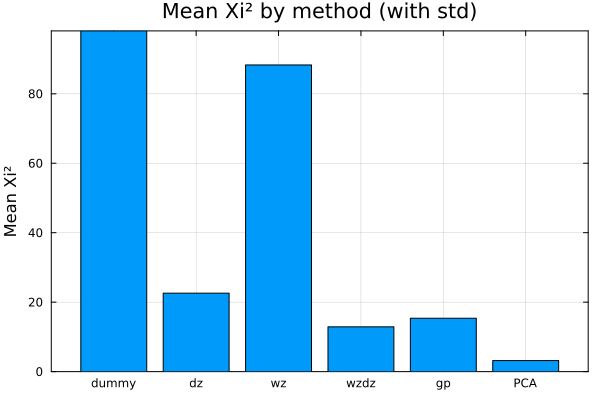

In [29]:
# Annotated bar plot of the mean Xi2 values (uses Xi2_* arrays already defined)
means = [
    mean(Xi2_dummy),
    mean(Xi2_dz),
    mean(Xi2_wz),
    mean(Xi2_wzdz),
    mean(Xi2_gp),
    mean(Xi2_PCA)
]


labels = ["dummy", "dz", "wz", "wzdz", "gp", "PCA"]

bar(labels, means;
    legend=false,
    ylabel="Mean Xi²",
    title="Mean Xi² by method (with std)",
    framestyle = :box)

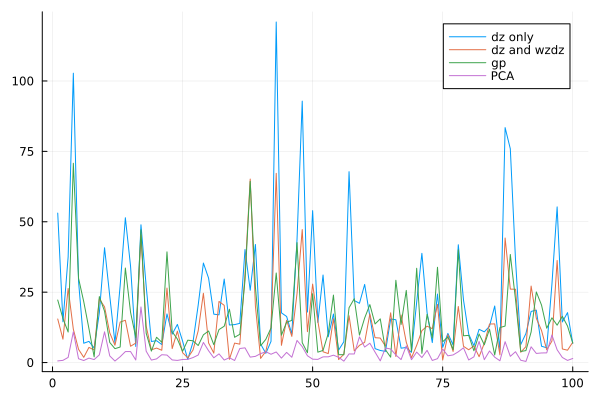

In [25]:
plot(Xi2_dz, label="dz only")
plot!(Xi2_wzdz, label="dz and wzdz")
plot!(Xi2_gp, label="gp")
plot!(Xi2_PCA, label="PCA")

In [8]:
realization = 1  # Change this to generate different realizations
dz_0 = dz_params["lens_0"][:, realization]
dz_1 = dz_params["lens_1"][:, realization]
dz_2 = dz_params["lens_2"][:, realization]
dz_3 = dz_params["lens_3"][:, realization]
dz_4 = dz_params["lens_4"][:, realization]
dz_5 = dz_params["source_0"][:, realization]
dz_6 = dz_params["source_1"][:, realization]
dz_7 = dz_params["source_2"][:, realization]
dz_8 = dz_params["source_3"][:, realization]
dz_9 = dz_params["source_4"][:, realization]

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["photo_hists"][:, realization]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["photo_hists"][:, realization]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["photo_hists"][:, realization]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["photo_hists"][:, realization]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["photo_hists"][:, realization]
zs_k5, nz_k5 = nz_source_0["z"], nz_source_0["photo_hists"][:, realization]
zs_k6, nz_k6 = nz_source_1["z"], nz_source_1["photo_hists"][:, realization]
zs_k7, nz_k7 = nz_source_2["z"], nz_source_2["photo_hists"][:, realization]
zs_k8, nz_k8 = nz_source_3["z"], nz_source_3["photo_hists"][:, realization]
zs_k9, nz_k9 = nz_source_4["z"], nz_source_4["photo_hists"][:, realization]

_nz_lens_0 = Dict("z" => zs_k0, "dndz" => nz_k0)
_nz_lens_1 = Dict("z" => zs_k1, "dndz" => nz_k1)
_nz_lens_2 = Dict("z" => zs_k2, "dndz" => nz_k2)
_nz_lens_3 = Dict("z" => zs_k3, "dndz" => nz_k3)
_nz_lens_4 = Dict("z" => zs_k4, "dndz" => nz_k4)
_nz_source_0 = Dict("z" => zs_k5, "dndz" => nz_k5)
_nz_source_1 = Dict("z" => zs_k6, "dndz" => nz_k6)
_nz_source_2 = Dict("z" => zs_k7, "dndz" => nz_k7)
_nz_source_3 = Dict("z" => zs_k8, "dndz" => nz_k8)
_nz_source_4 = Dict("z" => zs_k9, "dndz" => nz_k9)

_, new_files = make_data(sacc_file, yaml_file;
    nz_lens_0=_nz_lens_0,
    nz_lens_1=_nz_lens_1,
    nz_lens_2=_nz_lens_2,
    nz_lens_3=_nz_lens_3,
    nz_lens_4=_nz_lens_4,
    nz_source_0=_nz_source_0,
    nz_source_1=_nz_source_1,
    nz_source_2=_nz_source_2,
    nz_source_3=_nz_source_3,
    nz_source_4=_nz_source_4)

fake_data = make_theory(files=new_files);
fake_data = iΓ * fake_data
data = fake_data

cond_model = model(data;
    files=files,
    dz_lens_0=dz_0,
    dz_lens_1=dz_1,
    dz_lens_2=dz_2,
    dz_lens_3=dz_3,
    dz_lens_4=dz_4,
    dz_source_0=dz_5,
    dz_source_1=dz_6,
    dz_source_2=dz_7,
    dz_source_3=dz_8,
    dz_source_4=dz_9)

LoadError: UndefVarError: `dz_params` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
using OptimizationOptimJL: NelderMead
mle = maximum_likelihood(cond_model, NelderMead())

In [ ]:
values = mle.values.array
namess = mle.values.dicts[1].keys

In [ ]:
params = Dict{Symbol, Float64}()
for (i, name) in enumerate(namess)
    params[Symbol(name)] = values[i]
end

In [ ]:
 CSV.write("./test.csv", DataFrame(params), append=true)

In [ ]:
typeof(mle_estimate.values)

In [ ]:
CSV.write(mle_estimate.values.array, "mle_estimate.csv")

In [ ]:
plot(meta_gcgc.data, yscale=:log10, label="Data - gcgc")
plot!(t_gcgc, label="Theory - gcgc")

In [ ]:
break

In [ ]:
npzwrite("data/CosmoDC2/theories.npz", 
    t_wlwl=t_wlwl,
    t_gcgc=t_gcgc,
    t_3x2=t_3x2)

In [ ]:
A_IAs = Vector(range(-1.0, 1.0, length=200));

In [ ]:
A_IAs = range(-1.0, 1.0, length=200)
IA_xi2_3x2 = [model_3x2(A_IA=A_IA, data=t_3x2)[2] for A_IA in A_IAs]
IA_xi2_wlwl = [model_wlwl(A_IA=A_IA, data=t_wlwl)[2] for A_IA in A_IAs];

In [ ]:
plot(A_IAs, IA_xi2_wlwl, label="wlwl")
plot!(A_IAs, IA_xi2_3x2, label="3x2")

In [ ]:
dzs = zeros(5)
wzs = ones(5)
es = LinRange(-0.2, 0.2, 200)
dzs_xi2_3x2 = [model_3x2(dzs_lens=dzs .+ e, dzs_source=dzs .+ e, data=t_3x2)[2] for e in es]
dzs_xi2_gcgc = [model_gcgc(dzs_lens=dzs .+ e, data=t_gcgc)[2] for e in es]
dzs_xi2_wlwl = [model_wlwl(dzs_source=dzs .+ e, data=t_wlwl)[2] for e in es]

In [ ]:
plot(es, dzs_xi2_gcgc, label="gcgc")
plot!(es, dzs_xi2_wlwl, label="wlwl")
plot!(es, dzs_xi2_3x2, label="3x2")

In [ ]:
wzs_xi2_3x2 = [model_3x2(wzs_lens=wzs .+ e, wzs_source=wzs .+ e, data=t_3x2)[2] for e in es]
wzs_xi2_gcgc = [model_gcgc(wzs_lens=wzs .+ e, data=t_gcgc)[2] for e in es]
wzs_xi2_wlwl = [model_wlwl(wzs_source=wzs .+ e, data=t_wlwl)[2] for e in es]

In [ ]:
plot(es, wzs_xi2_gcgc, label="gcgc", yscale = :log10)
plot!(es, wzs_xi2_wlwl, label="wlwl")
plot!(es, wzs_xi2_3x2, label="3x2")

In [ ]:
#using ForwardDiff
#function grad_h(h)
#    function f(h)
#        t, Xi2 = model_3x2(;Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=h, ns=0.99651,
#            meta=meta_3x2, files=files_3x2, data=t_3x2)
#        return Xi2
#    end
#    return ForwardDiff.derivative(f, h)
#end

#function grad_Wm(Wm)
#    function f(Wm)
#        t, Xi2 = model_3x2(;Ωm=Wm, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
#            meta=meta_3x2, files=files_3x2, data=t_3x2)
#        return Xi2
#    end
#    return ForwardDiff.derivative(f, Wm)
#end

In [ ]:
Wm = range(0.2, 0.5, length=200)
Wb = range(0.03, 0.07, length=200)
h  = range(0.6, 0.9, length=200)
s8 = range(0.4, 1.2, length=200)
ns = range(0.84, 1.1, length=200)

In [ ]:
#Wm_grads = [grad_Wm(Wm_i) for Wm_i in Wm]
Wm_xi2_3x2 = [model_3x2(;Ωm=Wm_i, data=t_3x2)[2] for Wm_i in Wm]
Wm_xi2_gcgc = [model_gcgc(;Ωm=Wm_i, data=t_gcgc)[2] for Wm_i in Wm]
Wm_xi2_wlwl = [model_wlwl(;Ωm=Wm_i, data=t_wlwl)[2] for Wm_i in Wm];

In [ ]:
#Wb_grads = [grad_Wm(Wm_i) for Wm_i in Wm]
Wb_xi2_3x2 = [model_3x2(;Ωb=Wb_i, data=t_3x2)[2] for Wb_i in Wb]
Wb_xi2_gcgc = [model_gcgc(;Ωb=Wb_i, data=t_gcgc)[2] for Wb_i in Wb]
Wb_xi2_wlwl = [model_wlwl(;Ωb=Wb_i, data=t_wlwl)[2] for Wb_i in Wb];

In [ ]:
#h_grads = [grad_h(h_i) for h_i in h]
h_xi2_3x2 = [model_3x2(;h=h_i, data=t_3x2)[2] for h_i in h]
h_xi2_gcgc = [model_gcgc(;h=h_i, data=t_gcgc)[2] for h_i in h]
h_xi2_wlwl = [model_wlwl(;h=h_i, data=t_wlwl)[2] for h_i in h];

In [ ]:
#s8_grads = [grad_Wm(s8_i) for Wm_i in Wm]
s8_xi2_3x2 = [model_3x2(;σ8=s8_i, data=t_3x2)[2] for s8_i in s8]
s8_xi2_gcgc = [model_gcgc(;σ8=s8_i, data=t_gcgc)[2] for s8_i in s8]
s8_xi2_wlwl = [model_wlwl(;σ8=s8_i, data=t_wlwl)[2] for s8_i in s8];

In [ ]:
#ns_grads = [grad_Wm(ns_i) for ns_i in ns]
ns_xi2_3x2 = [model_3x2(;ns=ns_i, data=t_3x2)[2] for ns_i in ns]
ns_xi2_gcgc = [model_gcgc(;ns=ns_i, data=t_gcgc)[2] for ns_i in ns]
ns_xi2_wlwl = [model_wlwl(;ns=ns_i, data=t_wlwl)[2] for ns_i in ns];

In [ ]:
plot(h, h_xi2_3x2, label="h Xi2s - 3x2", yscale = :log10)
plot!(h, h_xi2_wlwl, label="h Xi2s - wlwl")
plot!(h, h_xi2_gcgc, label="h Xi2s - gcgc")

In [ ]:
plot(Wm, Wm_xi2_3x2, label="Wm Xi2s - 3x2", yscale = :log10)
plot!(Wm, Wm_xi2_wlwl, label="Wm Xi2s - wlwl")
plot!(Wm, Wm_xi2_gcgc, label="Wm Xi2s - gcgc")

In [ ]:
npzwrite("data/CosmoDC2/gradients.npz",
    h=h,
    Wm=Wm,
    Wb=Wb,
    ns=ns,
    s8=s8, 
    Wm_xi2_3x2=Wm_xi2_3x2,
    Wm_xi2_gcgc=Wm_xi2_gcgc,
    Wm_xi2_wlwl=Wm_xi2_wlwl,
    Wb_xi2_3x2=Wb_xi2_3x2,
    Wb_xi2_gcgc=Wb_xi2_gcgc,
    Wb_xi2_wlwl=Wb_xi2_wlwl,
    h_xi2_3x2=h_xi2_3x2,
    h_xi2_gcgc=h_xi2_gcgc,
    h_xi2_wlwl=h_xi2_wlwl,
    s8_xi2_3x2=s8_xi2_3x2,
    s8_xi2_gcgc=s8_xi2_gcgc,
    s8_xi2_wlwl=s8_xi2_wlwl,
    ns_xi2_3x2=ns_xi2_3x2,
    ns_xi2_gcgc=ns_xi2_gcgc,
    ns_xi2_wlwl=ns_xi2_wlwl)